In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [54]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [55]:
trans_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
identity_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [5]:
trans_data.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

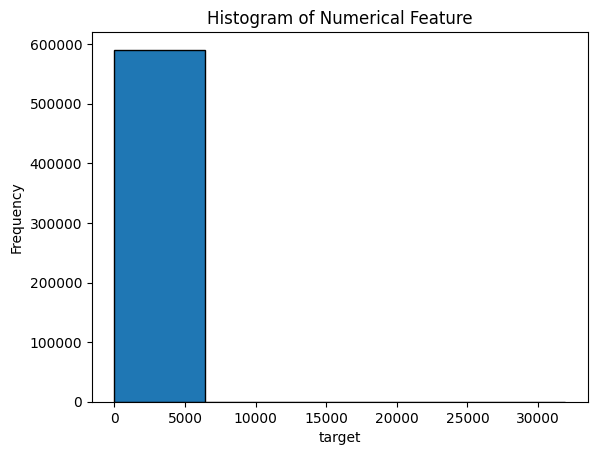

In [15]:
import matplotlib.pyplot as plt
plt.hist(trans_data['TransactionAmt'], bins=5, edgecolor='black')
plt.xlabel('target')
plt.ylabel('Frequency')
plt.title('Histogram of Numerical Feature')
plt.show()

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve,roc_curve, auc

In [57]:
Y = trans_data['isFraud'].copy()
x_cols = [c for c in trans_data.columns if c != 'isFraud']
x_data = trans_data[x_cols].copy()
x_train, T_x, y_train, T_y = train_test_split(x_data, Y,test_size = 0.2, random_state=42) 
x_val, x_test, y_val, y_test = train_test_split(T_x, T_y,test_size = 0.5, random_state=42)

In [ ]:
trans_data.shape

In [ ]:
trans_data.sort_values(by='TransactionDT',inplace=True)

In [ ]:
split_ratio = [0.7,0.15,0.15]
split_index = [int(len(trans_data) * split_ratio[0]),int(len(trans_data) * (split_ratio[0]+split_ratio[1]))]

x_data = pd.merge(trans_data,identity_data,on='TransactionID',how='left')
y = x_data['isFraud'].copy()
x_train = x_data.iloc[:split_index[0]].copy()
x_val = x_data.iloc[split_index[0]:split_index[1]].copy()
x_test = x_data.iloc[split_index[1]:].copy()

x_train.pop('isFraud')
x_val.pop('isFraud')
x_test.pop('isFraud')

y_train = y.iloc[:split_index[0]].copy()
y_val = y.iloc[split_index[0]:split_index[1]].copy()
y_test = y.iloc[split_index[1]:].copy()

Cleaning

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyImputer(BaseEstimator,TransformerMixin):
    def __init__(self,strategy:str = 'most_frequent'):
        self.imputer = None
        self.strategy = strategy

    def fit(self, x, y=None):
        x_copy = x.copy()
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(x_copy)
        return self

    def transform(self, x):
        x_transformed = x.copy()
        ret_val = pd.DataFrame(self.imputer.transform(x),columns=x_transformed.columns)

        return ret_val.astype(x_transformed.dtypes)

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

class CatToNum(BaseEstimator,TransformerMixin):
    def __init__(self,threshold:int = 3):
        self.woe_mappings = {}
        self.woe_columns = []
        self.woe_columns_fill_na = {}
        self.one_hot_cols = []
        self.threshold = threshold
        self.one_hot = None

    def fit(self, X, y=None):
        # Generate Fill Na Values Just in Case
        X_copy = X.copy()

        self.one_hot = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
        self.one_hot_cols = [c for c in X.columns if X[c].dtype == 'object' and X[c].nunique()>self.threshold]
        self.one_hot.fit(X_copy[self.one_hot_cols])        
        
        woe_columns = [c for c in X.columns if X[c].dtype == 'object' and X[c].nunique()<=self.threshold]
        if len(woe_columns)==0:
            self.woe_columns = []
            return self
        
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X[woe_columns].copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            
            woe_mappings[col] = woe_dict

        self.woe_mappings = woe_mappings
        self.woe_columns = woe_columns

    
        return self

    def transform(self, x):
        x_transformed = x.copy()
        for col in self.woe_columns:
            x_transformed[f'{col}_woe'] = x_transformed[col].map(self.woe_mappings[col])
            x_transformed.drop(columns=[col], inplace=True)

            x_transformed[f'{col}_woe'] = x_transformed[f'{col}_woe'].fillna(
                self.woe_mappings[col][self.woe_columns_fill_na[col]]
            )

        hot_cols = x_transformed[self.one_hot_cols]
        one_hot =  pd.DataFrame(self.one_hot.transform(hot_cols),columns=self.one_hot.get_feature_names_out())
        x_transformed.drop(columns=self.one_hot_cols,inplace=True)
        # print(x_transformed[self.woe_columns])
        return x_transformed     

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder

class MyTargetEncoder(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
        self.encoder = TargetEncoder(smooth="auto")
        self.target_cols = []
    
    def fit(self, X:pd.DataFrame, y=None):
        self.target_cols = [c for c in X.columns if X[c].dtype == 'object']
        self.encoder.fit(X[self.target_cols].copy(),y)
        return self

    def transform(self, X):
        x_copy = X.copy()
        x_copy[self.target_cols] = self.encoder.transform(x_copy[self.target_cols])
        return x_copy

In [37]:
l = [c for c in x_train.columns if x_train[c].dtype == 'object']

array([[0.02047364, 0.03446191, 0.02408901, ..., 0.01952218, 0.02183761,
        0.01806896],
       [0.11520737, 0.03446191, 0.06636573, ..., 0.04519737, 0.045199  ,
        0.045199  ],
       [0.02048041, 0.03452519, 0.02410977, ..., 0.04512482, 0.04512665,
        0.04512665],
       ...,
       [0.02034825, 0.03445452, 0.02389099, ..., 0.02211236, 0.0163982 ,
        0.01786332],
       [0.02036916, 0.03454141, 0.02399775, ..., 0.04540213, 0.04540398,
        0.04540398],
       [0.02036402, 0.03463852, 0.06645242, ..., 0.04538375, 0.04538539,
        0.04538539]])

Feature Engineering

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class Scaler(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
        self.scaler = scaler
        self.num_cols = []

    def fit(self, X:pd.DataFrame, y=None):
        if self.scaler == None:
            return self
        self.num_cols = [c for c in X if X[c].dtype != 'object']
        df_copy = X[self.num_cols].copy()
        
        self.scaler.fit(X[self.num_cols].copy())
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.scaler == None:
            return X_copy
        X_copy[self.num_cols] = pd.DataFrame(self.scaler.transform(X_copy[self.num_cols]),columns=self.num_cols)
        return X_copy

feature selection

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

class NaHeavy(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.drop_cols = []

    def fit(self, x, y=None):
        self.drop_cols = [c for c in x.columns if x[c].isna().sum() > x.shape[0]*self.threshold]
        return self

    def transform(self, x):
        print(f'Na dropped {len(self.drop_cols)} features')
        return x.drop(columns = self.drop_cols)

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.features_to_drop = []

    def fit(self, X:pd.DataFrame, y):
        num_cols = [c for c in X.columns if X[c].dtype != 'object']
        X_copy = X[num_cols].copy()
        X_copy['target'] = y
        corr_matrix = X_copy.corr().abs()

        target_cor = corr_matrix.pop('target')
        corr_matrix.drop(labels='target', axis=0,inplace=True)
        
        high_corr_pairs = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))


        features_to_drop = set()
        for feat1, feat2, _ in high_corr_pairs:
            if target_cor[feat1] < target_cor[feat2]:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)
        self.features_to_drop = list(features_to_drop)
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        print('corr dropped: ',len(self.features_to_drop))
        return X_copy.drop(columns=self.features_to_drop)

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

class VarianceFilter(BaseEstimator,TransformerMixin):
    def __init__(self, left_threshold:float = 0.003, right_threshold:float=50.00):
        self.left_threshold = left_threshold
        self.right_threshold = right_threshold
        self.drop_features = []

    def fit(self, X:pd.DataFrame, y):
        num_values = [c for c in X.columns if X[c].dtype != 'object']
        l = []

        for c in X.columns:
            counts = X[c].value_counts()
            all_c = X.shape[0]-X[c].isna().sum()
            if ((float(max(counts))/float(all_c)*100.00) > self.right_threshold or 
                (float(max(counts))/float(all_c)*100.00) < self.left_threshold):
                l.append(c)
        
        self.drop_features = l
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        print('var dropped : ',len(self.drop_features))
        return X_copy.drop(columns=self.drop_features)

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomSelector(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.columns = ['TransactionID','id_05','id_06','id_09','id_10','id_11','id_17','id_18','id_22','id_24','id_25','id_32','id_27','id_36', 'id_37','DeviceInfo','M1']
        
    def fit(self, X:pd.DataFrame, y):
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        print(f'selector dropped {len(self.columns)}')
        return X_copy.drop(columns=self.columns)

In [66]:
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
class CustomRFE(BaseEstimator,TransformerMixin):
    def __init__(self, feature_to_select):
        self.feature_to_select = feature_to_select
        self.rfe = RFE(
            estimator=XGBClassifier(max_depth=40,reg_lambda=10),
            n_features_to_select=feature_to_select,
        )
        self.dropped_features = []
        self.selected_features = []

    def fit(self, X:pd.DataFrame, y=None):
        self.rfe.fit(X.copy(),y.copy())

        cols = X.columns
        selected = self.rfe.support_

        # Get selected and dropped features
        self.selected_features = cols[selected]
        self.dropped_features = cols[~selected]

        return self

    def transform(self, X):
        X_copy = X.copy()
        print('rfe dropped: ',len(self.dropped_features))
        res = X_copy[self.selected_features]
        return res

    def get_features()-> list[str]:
        return self.dropped_features

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
class LogisticFilter(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int=0.05):
        self.threshold = threshold
        self.drop_features = []
        
    def fit(self, X:pd.DataFrame, y=None):
        log_model = LogisticRegression()
        log_model.fit(X,y)

        weights = log_model.coef_[0]
        feature_names = X.columns
        feature_weights = pd.DataFrame({'Feature': feature_names, 'Weight': weights})

        feature_weights['Weight'] = feature_weights['Weight'].abs()

        self.drop_features = [feature_weights.iloc[i].iloc[0] for i in range(feature_weights.shape[0]) if feature_weights.iloc[i].iloc[1]<=self.threshold]
        
        return self

    def transform(self, X):
        print(f"logistic dropped {len(self.drop_features)} features")
        return X.drop(columns = self.drop_features)

In [ ]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [68]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [69]:
pipeline = Pipeline(steps=[
        # ('slector', CustomSelector()),
        ('naheavy', NaHeavy(0.9)),
        ('var_filter', VarianceFilter(0.00, 85.00)),
        ('imputer', MyImputer()),
        ('corr',CorrelationFilter(0.98)),
        # ('cat2num', CatToNum(5)),
        ('cat2num', MyTargetEncoder()),
        ('scaler', Scaler()),
        # ('logistic_filter',LogisticFilter(0.015)),
        ('model', XGBClassifier(n_estimators=200,max_depth=40,reg_lambda=250))
    ])

imb_pipeline = ImbPipeline(steps=[
    ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.1)),
    ('oversampler', RandomOverSampler(random_state=42, sampling_strategy=0.40))
])

In [43]:
x_train_sampled, y_train_resampled = imb_pipeline.fit_resample(x_train,y_train)

In [22]:
prep = Pipeline(steps=pipeline.steps[:-1])

In [23]:
prep_model = prep.fit(x_train,y_train)

Na dropped 2 features
var dropped :  232
corr dropped:  28


In [24]:
# proccesed_sample = prep_model.transform(x_train_sampled)
procesed_train = prep_model.transform(x_train)
processed_val = prep_model.transform(x_val)

Na dropped 2 features
var dropped :  232
corr dropped:  28
Na dropped 2 features
var dropped :  232
corr dropped:  28


In [ ]:
procesed_train

In [ ]:
c = CustomRFE(70)

In [ ]:
procesed_train

In [ ]:
refed = CustomRFE(70).fit_transform(procesed_train,y_train)

In [26]:
params_max_depth = [10,20,30,40,50]
params_rel_lambda = [100]
for p in params_max_depth:
    for p1 in params_rel_lambda:
        c = Pipeline(steps=[
            # ('slector', CustomSelector()),
            # ('naheavy', NaHeavy(p)),
            # ('var_filter', VarianceFilter(0.00, 85.00)),
            # ('imputer', MyImputer()),
            # ('corr',CorrelationFilter(0.98)),
            # ('cat2num', CatToNum(p)),
            # ('scaler', Scaler()),
            # ('logistic_filter',LogisticFilter(0.015)),
            ('model', XGBClassifier(max_depth=p,reg_lambda=250))
        ])
        
        # c = Pipeline(steps=[
        #     # ('rfe', CustomRFE(340)),
        #     ('xgb',XGBClassifier(max_depth=40,reg_lambda=10))
        # ]) 
        
        
        mod = c.fit(procesed_train,y_train)
        train_proba = mod.predict_proba(procesed_train)
        val_proba = mod.predict_proba(processed_val)
    
        val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_proba[:,1])
        val_roc_auc = auc(val_fpr, val_tpr)
    
        val_precision, val_recall, thresholds = precision_recall_curve(y_val, val_proba[:,1])
        val_auc_pr = auc(val_recall, val_precision)
    
        train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba[:,1])
        train_roc_auc = auc(train_fpr, train_tpr)
    
        train_precision, train_recall, thresholds = precision_recall_curve(y_train, train_proba[:,1])
        train_auc_pr = auc(train_recall, train_precision)
        print('p: p1:',p,p1)
        print('val_roc: ',val_roc_auc)
        print('val_pr: ', val_auc_pr)
        print('train_roc: ', train_roc_auc)
        print('train_pr: ', train_auc_pr)
        print('##############################')

p: p1: 10 100
val_roc:  0.9353260942294039
val_pr:  0.6878534714971599
train_roc:  0.958250705493289
train_pr:  0.7655669982534954
##############################
p: p1: 20 100
val_roc:  0.9487028818010619
val_pr:  0.7504813870921524
train_roc:  0.9831609983319539
train_pr:  0.8827275662831616
##############################
p: p1: 30 100
val_roc:  0.9499069262512112
val_pr:  0.7546015135666785
train_roc:  0.986455970608289
train_pr:  0.8979440318774436
##############################
p: p1: 40 100
val_roc:  0.950389203463645
val_pr:  0.7530345448915725
train_roc:  0.9866479020235654
train_pr:  0.8994184043036082
##############################
p: p1: 50 100
val_roc:  0.9509975718842058
val_pr:  0.753639154103232
train_roc:  0.9868568286762911
train_pr:  0.9007020466837731
##############################


In [70]:
model = pipeline.fit(x_train, y_train)

Na dropped 2 features
var dropped :  232
corr dropped:  28


In [ ]:
print(model.steps[-2].get_features())

In [71]:
train_proba = model.predict_proba(x_train)

Na dropped 2 features
var dropped :  232
corr dropped:  28


In [72]:
val_proba = model.predict_proba(x_val)

Na dropped 2 features
var dropped :  232
corr dropped:  28


In [ ]:
val_proba

In [ ]:
train_pred

In [73]:
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_proba[:,1])
val_roc_auc = auc(val_fpr, val_tpr)
val_roc_auc

0.9595262740441639

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Print the AUC value
print(f"AUC: {val_roc_auc:.2f}")

In [74]:
val_precision, val_recall, thresholds = precision_recall_curve(y_val, val_proba[:,1])
val_auc_pr = auc(val_recall, val_precision)
val_auc_pr

0.7958663721564005

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(val_recall,val_precision, color='b', lw=2,
         label=f'Precision-Recall curve (AUC-PR = {val_auc_pr:.2f})')
plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print(f"AUC-PR: {val_auc_pr:.2f}")

In [75]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba[:,1])
train_roc_auc = auc(train_fpr, train_tpr)
train_roc_auc

0.9965805624452356

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Print the AUC value
print(f"AUC: {train_roc_auc:.2f}")

In [76]:
train_precision, train_recall, thresholds = precision_recall_curve(y_train, train_proba[:,1])
train_auc_pr = auc(train_recall, train_precision)
train_auc_pr

0.9661404869884772

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_recall,train_precision, color='b', lw=2,
         label=f'Precision-Recall curve (AUC-PR = {train_auc_pr:.2f})')
plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print(f"AUC-PR: {train_auc_pr:.2f}")

In [ ]:
test_prob = model.predict_proba(x_test)

In [54]:
test_precision, test_recall, thresholds = precision_recall_curve(y_test, test_prob[:,1])
val_auc_pr = auc(test_recall, test_precision)
val_auc_pr

NameError: name 'test_prob' is not defined

In [ ]:
trans = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

In [ ]:
new_cols = []
for col in identity.columns:
    new_col = col.replace('-', '_')
    new_cols.append(new_col)
identity.columns = new_cols

In [ ]:
data = pd.merge(trans,identity,on='TransactionID',how='left')

In [ ]:
predicted = model.predict_proba(data)

In [ ]:
submission = pd.DataFrame({'TransactionID': data['TransactionID'], 'isFraud': predicted[:,1]})  # Replace 'test_ids' and 'predictions'

# Save the DataFrame to a CSV file
submission.to_csv('submission1.csv', index=False)

In [55]:
import shap

In [ ]:
preprocess_steps = Pipeline(steps=pipeline.steps[:-1])

In [ ]:
preprocess_steps

In [ ]:
preprocessed = preprocess_steps.fit_transform(x_train,y_train)

In [ ]:
model1 = XGBClassifier(n_estimators=2000)
model1.fit(preprocessed,y_train)

In [ ]:
explainer = shap.Explainer(model1)

shap_values = explainer.shap_values(preprocessed)

In [77]:
!pip install -q dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 60.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [78]:
import dagshub
dagshub.init(repo_owner='azhgh22', repo_name='ML2_fraud_detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=8fb59af6-0172-4883-a3d3-6cb17c4657ba&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a54e46230fa361877e8aef9024de8b3e55a67761966fbd650ade799fb75d69a3




Accessing as azhgh22

Initialized MLflow to track repo "azhgh22/ML2_fraud_detection"

Repository azhgh22/ML2_fraud_detection initialized!

In [79]:
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

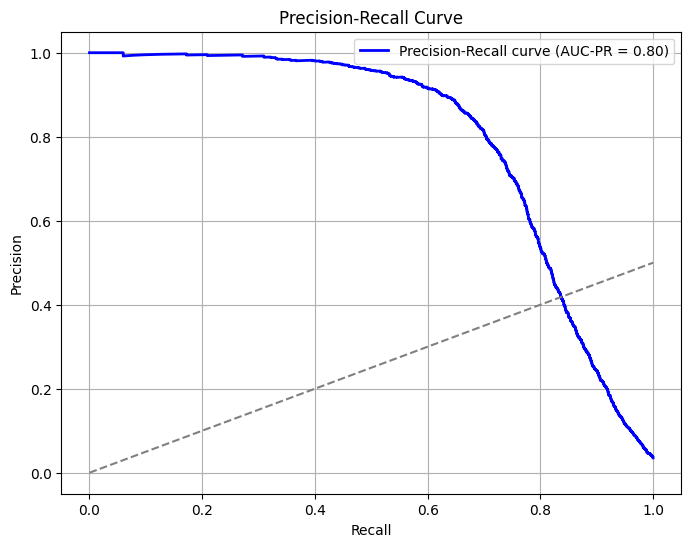

AUC-PR: 0.80


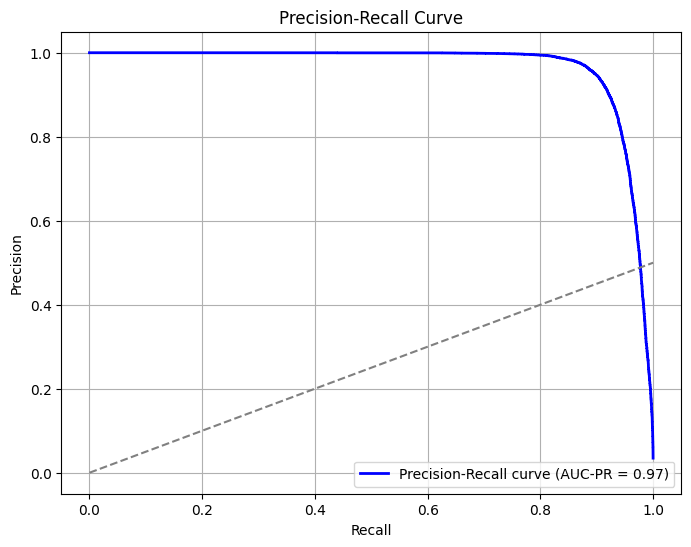

AUC-PR: 0.97


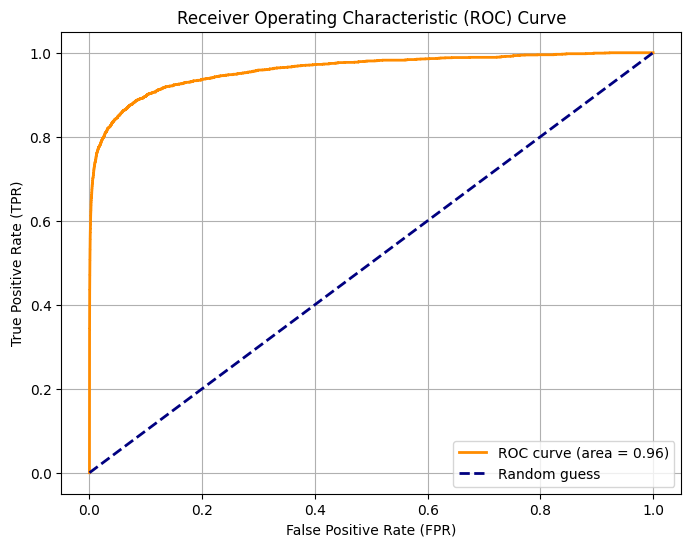

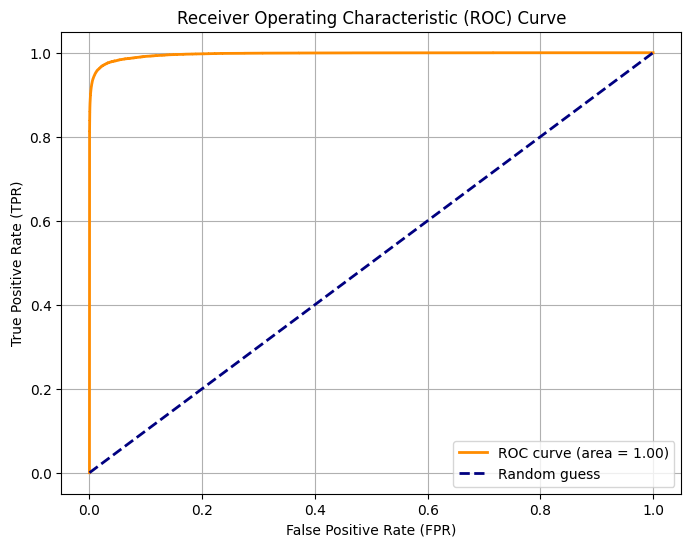

2025/04/27 06:56:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run xgboost:run7 at: https://dagshub.com/azhgh22/ML2_fraud_detection.mlflow/#/experiments/2/runs/e0649529cbd0480ba025c248e6cd189a
🧪 View experiment at: https://dagshub.com/azhgh22/ML2_fraud_detection.mlflow/#/experiments/2


In [81]:
mlflow.set_experiment("XGBoost")
with mlflow.start_run(run_name="xgboost:run7"):
    mlflow.log_params({
        # 'CustomSelector' : ['TransactionID','id_05','id_06','id_09','id_10','id_11','id_17','id_18','id_22','id_24','id_25','id_32','id_27','id_36', 'id_37','DeviceInfo','M1'],
        'used_tables' : ['transaction.csv'],
        # 'join method' : {
        #       'on' : 'TransactionID',
        #       'how' : 'left'
        # },
        'cross_val_split': {
            # 'sortdby' : 'TransactionDT',
            'method' : 'test_train_split',
            'train' : 0.8,
            'validation' : 0.1,
            'test' : 0.1,
            'random_state' : 42
        },
        'variation_filter' : {
            'left_threshold' : 0.002,
            'right_threshold' : 85.00
        },
        'drop_na_heavy_columns_threshold' : 0.9,
        'na imputer' : 'SimpleImputer(strategy=\'most_drequent\')',
        # 'categorical columns' : {
        #     '>threshold' : 'woe',
        #     '<=threshold' : 'one_hot'
        # },
        'categorical columns' : 'target_encoder',
        # 'cat2num_threshold' : 5,
        # 'correlation filter threshold' : 0.98,
        'scaler' : 'StandardScaler',
        # 'LogisticFilter_threshold' : 0.015, 
        # 'imb_pipline_steps' : {
        #     'step1' : 'undersampling',
        #     'step2' : 'oversampling'
        # },
        # 'undersampling' : {
        #     'class' : 'RandomUnderSampler',
        #     'random_state' : 42,
        #     'sampling_strategy' : 0.1
        # },
        # 'oversampling' : {
        #     'class' : 'RandomOverSampler',
        #     'random_state' : 42,
        #     'sampling_strategy' : 0.4
        # },
        'model' : 'XGboost',
        'n_estimators' : 200,
        'max_depth' : 40,
        'reg_lambda' : 250
    })
    mlflow.log_metrics({
        'train_roc_auc': train_roc_auc,
        'test__roc_auc' : val_roc_auc, 
        'train_pr_auc' : train_auc_pr,
        'val_pr_auc' : val_auc_pr
    })

    plt.figure(figsize=(8, 6))
    plt.plot(val_recall,val_precision, color='b', lw=2,
             label=f'Precision-Recall curve (AUC-PR = {val_auc_pr:.2f})')
    plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("val_roc_pr.png")
    plt.show()
    mlflow.log_artifact("val_roc_pr.png")
    print(f"AUC-PR: {val_auc_pr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(train_recall,train_precision, color='b', lw=2,
             label=f'Precision-Recall curve (AUC-PR = {train_auc_pr:.2f})')
    plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("train_roc_pr.png")
    plt.show()
    mlflow.log_artifact("train_roc_pr.png")
    print(f"AUC-PR: {train_auc_pr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("validation_roc.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("validation_roc.png")

    plt.figure(figsize=(8, 6))
    plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("train_roc.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("train_roc.png")
    
    mlflow.sklearn.log_model(model,'xgboost_with_identity')
    
    mlflow.end_run()

In [ ]:
cat_values = [c for c in x_train.columns if x_train[c].dtype == 'object']
num_values = [c for c in x_train.columns if x_train[c].dtype != 'object']
print(len(cat_values))
print(len(num_values))

In [ ]:
vs = pd.DataFrame()
vs.index = num_values
vs['std'] = x_train[num_values].std()

In [ ]:
vs['std'].describe(x/100 for x in range(2, 101, 2))

In [ ]:
# value_counts = x_train[num_values].value_counts()

In [ ]:
value_counts = x_train['TransactionAmt'].value_counts()
    

In [ ]:
value_counts.head(1).iloc[0]

In [ ]:
max(value_counts)

In [ ]:
sum(value_counts)

In [ ]:
l = [c for c in num_values if (float(max(x_train[c].value_counts()))/float(x_train.shape[0])*100.00) > 50.00 or (float(max(x_train[c].value_counts()))/float(x_train.shape[0])*100.00)<0.002]

In [ ]:
len(l)

In [ ]:
s = RandomUnderSampler(random_state=42, sampling_strategy=0.1)

In [ ]:
x,y = s.fit_resample(x_train, y_train)

In [ ]:
import matplotlib.pyplot as plt
num_values = [c for c in x.columns if x[c].dtype != 'object']
for c in num_values:
    plt.hist(x[c], bins=50, edgecolor='black')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.title('Histogram of Numerical Feature')
    plt.show()
    # print(vs['std'][c])
    # print(x_train[c].value_counts())
    value_counts = x[c].value_counts()
    print('max count:', max(value_counts))
    print('all rows : ',x.shape[0] - x[c].isna().sum())
    print('% :  ',(float(max(value_counts))/float(x.shape[0] - x[c].isna().sum())*100.00))
    print(x[c].nunique())

In [ ]:
import matplotlib.pyplot as plt
for c in num_values:
    plt.hist(x_train[c], bins=50, edgecolor='black')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.title('Histogram of Numerical Feature')
    plt.show()
    print(vs['std'][c])
    # print(x_train[c].value_counts())
    value_counts = x_train[c].value_counts()
    print('max count:', max(value_counts))
    print('all rows : ',x_train.shape[0])
    print('% :  ',(float(max(value_counts))/float(x_train.shape[0])*100.00))
    print(x_train[c].nunique())